### 主題: 抓取PTT八卦版的文章
- 關鍵字: 大谷翔平、大谷、翔平、Shohei、Ohtani、Shohei Ohtani
- 日期區間: 2022-01-01 ~ 2024-03-27

## 1. 套件說明
下面列出在本次過程中所使用到的相關套件:
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

In [39]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

In [40]:
!pip install pandas
!pip install matplotlib
!pip install wordcloud
!pip install jieba

In [41]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 2. 資料前處理
### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集PTT 八卦版 2022-01-01 ~ 2024-03-27

In [42]:
import urllib.request as req
import bs4
from datetime import datetime
import pandas as pd

df=pd.read_csv("sna2024s.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,a14589761,Gossiping,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a94037501"", ...",110.26.71.183,2022-01-04 00:38:35,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05,XBOXFANS,Gossiping,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zero9613719""...",118.232.67.100,2022-01-06 00:39:27,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09,ReiKuromiya,Gossiping,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ah937609"", ""...",101.10.57.169,2022-01-10 00:31:00,ptt


### 2.2資料清理

In [43]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還一個方斯...
1,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,1.媒體來源:三立。2.記者署名:娛樂中心／林亭妤報導。3.完整新聞標題:福原愛爆再婚被罵翻...
2,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,有沒有如果大谷翔平加入女偶像團體唱唱跳跳
3,https://www.ptt.cc/bbs/Gossiping/M.1642034050....,[新聞]曾被批評不會講英文！大谷翔平大笑：會,2022-01-13,1.媒體來源:ETTODAY\n\n2.記者署名:賴冠文\n\n3.完整新聞標題:\n曾被批...,1.媒體來源:ETTODAY。2.記者署名:賴冠文。3.完整新聞標題:曾被批評不會講英文！大...
4,https://www.ptt.cc/bbs/Gossiping/M.1642034603....,Re:[新聞]曾被批評不會講英文！大谷翔平大笑：會,2022-01-13,去了三四年還不會講英文？\n\n真的有心學英文的話 大概一年就可以多益800了拉\n\n簡單...,去了三四年還不會講英文？。真的有心學英文的話 大概一年就可以多益800了拉。簡單來說就是沒心...
...,...,...,...,...,...
2661,https://www.ptt.cc/bbs/Gossiping/M.1711505352....,Re:[問卦]八卦版怎麼一堆直接認定大谷簽賭,2024-03-27,就問一句\n\n一個會去涉賭的人，有可能主動要求球團把他的年薪延後到10年後才支付6800萬...,就問一句。一個會去涉賭的人，有可能主動要求球團把他的年薪延後到10年後才支付6800萬美金嗎...
2662,https://www.ptt.cc/bbs/Gossiping/M.1711506015....,[問卦]愛賭的還可以站上運動殿堂頭腦清不清楚?,2024-03-27,正在認真上班的各位安安阿~~啊我就那個心齋橋哥啦\n\n年輕的時候我就開始玩實況野球\n\n...,正在認真上班的各位安安阿~~啊我就那個心齋橋哥啦。年輕的時候我就開始玩實況野球。到去年的WB...
2663,https://www.ptt.cc/bbs/Gossiping/M.1711509101....,[問卦]☺為何大谷回天使主場沒被噓？,2024-03-27,欸欸欸\n\n我說妳各位啊\n\n剛才看到大谷回天使球場\n\n竟受到天使球迷熱烈鼓掌歡迎\...,欸欸欸。我說妳各位啊。剛才看到大谷回天使球場。竟受到天使球迷熱烈鼓掌歡迎。而且大谷還身穿道奇...
2664,https://www.ptt.cc/bbs/Gossiping/M.1711544981....,Re:[問卦]八卦版怎麼一堆直接認定大谷簽賭,2024-03-27,大谷本身簽賭的機會本來就很高\n\n應該說大谷就是主謀 怎麼可能把自己的帳戶交給別人保管\n...,大谷本身簽賭的機會本來就很高。應該說大谷就是主謀 怎麼可能把自己的帳戶交給別人保管。不就跟詐...


斷句

In [44]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,我在王建民那年代開始看大聯盟的
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,那時候看王建民投95、96麥感覺就超威
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,後面還一個方斯沃斯能投99麥就真的嚇死人
4,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,但是這幾年能投100麥的感覺一大票
...,...,...,...,...,...
31718,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,現在結婚真的有人在簽婚前協議書的嗎
31719,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,例如如果離婚 財產的3成要分給老婆
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,但如果不簽 老婆就逼你說你是不是不愛他
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,有沒有簽婚前協議書的八卦


初始化斷詞引擎

In [45]:


jieba.set_dictionary('dict.txt')
# jieba.load_userdict('dict/user_dict.txt')
# jieba.add_word('自助餐')


In [46]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,我在王建民那年代開始看大聯盟的
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,那時候看王建民投9596麥感覺就超威
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,後面還一個方斯沃斯能投99麥就真的嚇死人
4,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,但是這幾年能投100麥的感覺一大票
...,...,...,...,...,...
31717,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,但大谷這種身價就差很多了
31718,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,現在結婚真的有人在簽婚前協議書的嗎
31719,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,例如如果離婚 財產的3成要分給老婆
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,但如果不簽 老婆就逼你說你是不是不愛他


### 2.3 文章斷詞


In [47]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

Building prefix dict from c:\Users\fisha\OneDrive\桌面\社媒&intern\dict.txt ...
Loading model from cache C:\Users\fisha\AppData\Local\Temp\jieba.ubac966abe48a686925e6ae0302c2c088.cache
Loading model cost 0.698 seconds.
Prefix dict has been built successfully.


,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,王建民
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,年代
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,開始
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,大聯盟
...,...,...,...,...,...
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,不愛他
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,有沒有
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,婚前
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,協議書


移除停用字

In [48]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["八卦", "如題","開始","大聯盟","球場","球員","王建民","年代","後面","感覺","超威"]
stopwords.extend(stopwords_manual)

In [49]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,9596
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,還一個
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,方斯
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,沃斯
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,99
...,...,...,...,...,...
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,老婆
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,不愛他
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,有沒有
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,婚前


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，將匯入情緒字典後，再和斷詞後的文章進行合併

### 3.1 LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版 

In [50]:
# 讀取情緒字典
liwc_dict = pd.read_csv("liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併

In [51]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,2022-01-03,[問卦]為什麼大聯盟能投100英哩的變那麼多？,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,9596,NaN
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,2022-01-03,[問卦]為什麼大聯盟能投100英哩的變那麼多？,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,還一個,NaN
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,2022-01-03,[問卦]為什麼大聯盟能投100英哩的變那麼多？,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,方斯,NaN
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,2022-01-03,[問卦]為什麼大聯盟能投100英哩的變那麼多？,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,沃斯,NaN
4,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,2022-01-03,[問卦]為什麼大聯盟能投100英哩的變那麼多？,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,99,NaN
...,...,...,...,...,...,...
142527,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,2024-03-27,[問卦]真的有人在簽婚前財產協議書的嗎,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,老婆,NaN
142528,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,2024-03-27,[問卦]真的有人在簽婚前財產協議書的嗎,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,不愛他,NaN
142529,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,2024-03-27,[問卦]真的有人在簽婚前財產協議書的嗎,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,有沒有,NaN
142530,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,2024-03-27,[問卦]真的有人在簽婚前財產協議書的嗎,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,婚前,NaN


### 3.3 正負向情緒詞彙頻率折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們以不同的指標來看情緒的好壞


In [52]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

# 篩選情緒為 positive 或 negative 的資料
mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"]) # 依 artDate 進行排序
sentiment_count

,artDate,sentiments,size
2,2022-01-03,negative,1
5,2022-01-05,positive,2
8,2022-01-13,negative,6
9,2022-01-13,positive,13
11,2022-01-17,positive,3
...,...,...,...
1961,2024-03-25,positive,8
1966,2024-03-26,negative,67
1967,2024-03-26,positive,62
1971,2024-03-27,negative,5


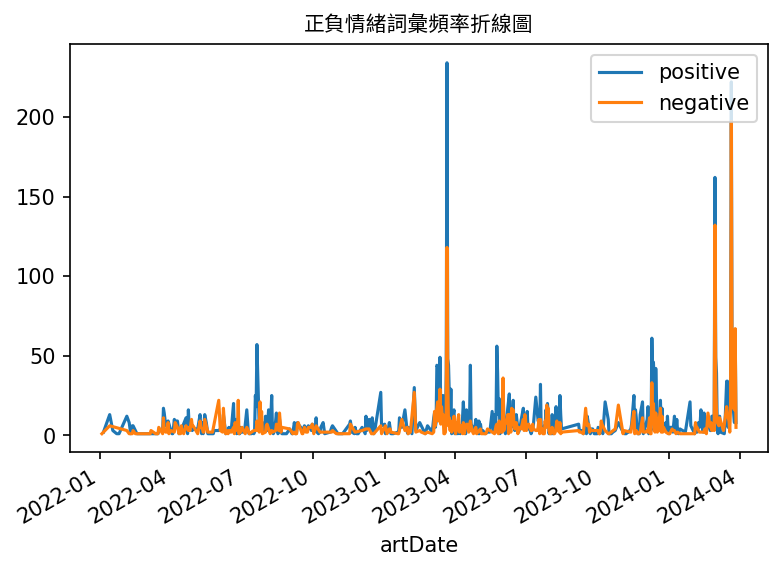

In [54]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

- 可以從圖中看出2023-03~2023-04 正面討論度特別高(WBC日本奪下冠軍，因此討論度特別高)
- 2024-03 因水原一平涉賭一案，因此負面聲量飆升

```Moving average```將時間序列數據平滑化，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。

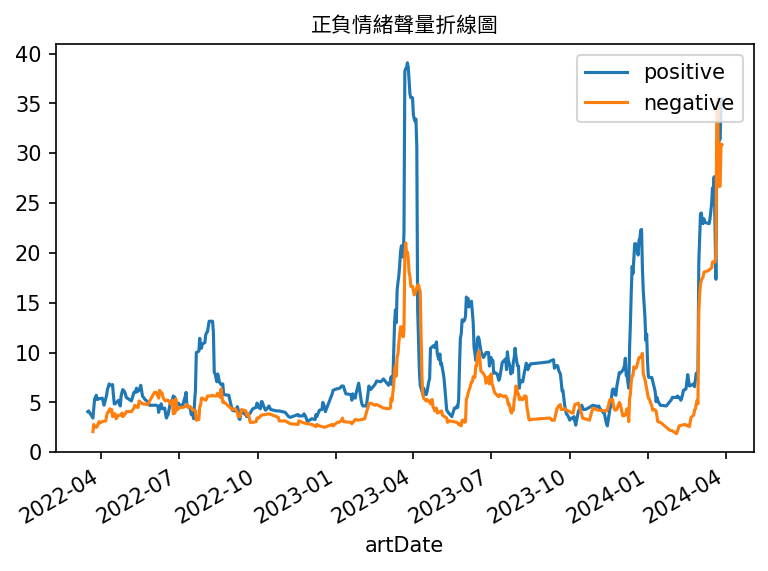

In [55]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  
plt.show()

- 此折線圖印證上述兩項論點

### 3.4以文章為單位的情緒分析

In [56]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,affect,1
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,anx,1
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,negative,1
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,sad,1
4,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,affect,2
...,...,...,...
5677,https://www.ptt.cc/bbs/Gossiping/M.1711544981....,affect,1
5678,https://www.ptt.cc/bbs/Gossiping/M.1711544981....,anger,1
5679,https://www.ptt.cc/bbs/Gossiping/M.1711544981....,negative,1
5680,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,affect,2


In [61]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,1,0,1,1,0,1,-1
1,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,2,0,0,0,2,0,2
2,https://www.ptt.cc/bbs/Gossiping/M.1642034050....,18,5,0,6,10,0,4
3,https://www.ptt.cc/bbs/Gossiping/M.1642034603....,1,0,0,0,1,0,1
4,https://www.ptt.cc/bbs/Gossiping/M.1642036785....,2,0,0,0,2,0,2


In [62]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,1,0,1,1,0,1,-1,負向
1,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,2,0,0,0,2,0,2,正向
2,https://www.ptt.cc/bbs/Gossiping/M.1642034050....,18,5,0,6,10,0,4,正向
3,https://www.ptt.cc/bbs/Gossiping/M.1642034603....,1,0,0,0,1,0,1,正向
4,https://www.ptt.cc/bbs/Gossiping/M.1642036785....,2,0,0,0,2,0,2,正向
...,...,...,...,...,...,...,...,...,...
1858,https://www.ptt.cc/bbs/Gossiping/M.1711505352....,2,0,0,0,2,0,2,正向
1859,https://www.ptt.cc/bbs/Gossiping/M.1711506015....,3,0,0,0,1,0,1,正向
1860,https://www.ptt.cc/bbs/Gossiping/M.1711509101....,2,0,0,0,2,0,2,正向
1861,https://www.ptt.cc/bbs/Gossiping/M.1711544981....,1,1,0,1,0,0,-1,負向


In [63]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,a14589761,Gossiping,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a94037501"", ...",110.26.71.183,2022-01-04 00:38:35,ptt,負向
1,2,https://www.ptt.cc/bbs/Gossiping/M.1641393082....,[新聞]福原愛爆再婚被罵翻！懶甩酸民突喊「永,2022-01-05,XBOXFANS,Gossiping,1.媒體來源:\n三立\n\n2.記者署名:\n娛樂中心／林亭妤報導\n\n3.完整新聞標題...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zero9613719""...",118.232.67.100,2022-01-06 00:39:27,ptt,正向
2,3,https://www.ptt.cc/bbs/Gossiping/M.1641662959....,[問卦]如果大谷翔平加入女團打工,2022-01-09,ReiKuromiya,Gossiping,有沒有如果大谷翔平加入女偶像團體唱唱跳跳\nhttps://i.imgur.com/XKkw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ah937609"", ""...",101.10.57.169,2022-01-10 00:31:00,ptt,NaN
3,4,https://www.ptt.cc/bbs/Gossiping/M.1642034050....,[新聞]曾被批評不會講英文！大谷翔平大笑：會,2022-01-13,polanco,Gossiping,1.媒體來源:ETTODAY\n\n2.記者署名:賴冠文\n\n3.完整新聞標題:\n曾被批...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Padfoneman"",...",42.77.137.218,2022-01-14 00:53:35,ptt,正向
4,5,https://www.ptt.cc/bbs/Gossiping/M.1642034603....,Re:[新聞]曾被批評不會講英文！大谷翔平大笑：會,2022-01-13,zxc0312,Gossiping,去了三四年還不會講英文？\n\n真的有心學英文的話 大概一年就可以多益800了拉\n\n簡單...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ak93"", ""cmtC...",133.203.232.64,2022-01-14 00:53:44,ptt,正向
...,...,...,...,...,...,...,...,...,...,...,...,...
2661,2662,https://www.ptt.cc/bbs/Gossiping/M.1711505352....,Re:[問卦]八卦版怎麼一堆直接認定大谷簽賭,2024-03-27,plauge,Gossiping,就問一句\n\n一個會去涉賭的人，有可能主動要求球團把他的年薪延後到10年後才支付6800萬...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""VVizZ"", ""cmt...",114.24.109.58,2024-03-28 01:28:46,ptt,正向
2662,2663,https://www.ptt.cc/bbs/Gossiping/M.1711506015....,[問卦]愛賭的還可以站上運動殿堂頭腦清不清楚?,2024-03-27,dennistao,Gossiping,正在認真上班的各位安安阿~~啊我就那個心齋橋哥啦\n\n年輕的時候我就開始玩實況野球\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ssaprevo"", ""...",59.126.46.96,2024-03-28 01:28:46,ptt,正向
2663,2664,https://www.ptt.cc/bbs/Gossiping/M.1711509101....,[問卦]☺為何大谷回天使主場沒被噓？,2024-03-27,aventardorsv,Gossiping,欸欸欸\n\n我說妳各位啊\n\n剛才看到大谷回天使球場\n\n竟受到天使球迷熱烈鼓掌歡迎\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""onion10021"",...",49.216.46.17,2024-03-28 01:29:11,ptt,正向
2664,2665,https://www.ptt.cc/bbs/Gossiping/M.1711544981....,Re:[問卦]八卦版怎麼一堆直接認定大谷簽賭,2024-03-27,wanubz9v,Gossiping,大谷本身簽賭的機會本來就很高\n\n應該說大谷就是主謀 怎麼可能把自己的帳戶交給別人保管\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""egghan"", ""cm...",114.137.13.225,2024-03-28 01:34:55,ptt,負向


In [64]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2022-01-03,負向,1
1,2022-01-05,正向,1
2,2022-01-13,正向,3
3,2022-01-17,正向,1
4,2022-01-22,正向,1
...,...,...,...
684,2024-03-25,負向,7
685,2024-03-26,正向,11
686,2024-03-26,負向,15
687,2024-03-27,正向,4


### 3.7 情緒代表字

In [57]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
872,打擊,negative,272
871,打擊,anx,272
870,打擊,affect,272
873,打擊,sad,272
382,問題,affect,163
...,...,...,...
1037,景仰,positive,1
1048,暴怒,affect,1
1049,暴怒,anger,1
1050,暴怒,negative,1


In [58]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
222,冠軍,positive,159
612,希望,positive,157
398,喜歡,positive,155
1089,樂天,positive,95
1475,笑死,positive,86
852,成功,positive,76
1146,決定,positive,67
558,完美,positive,65
1835,重要,positive,65
616,幫助,positive,62


In [59]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
872,打擊,negative,272
383,問題,negative,163
310,受傷,negative,56
1446,禁止,negative,45
982,擊敗,negative,42
1888,震驚,negative,40
427,嚴重,negative,38
885,打破,negative,36
1873,離婚,negative,35
441,垃圾,negative,32


c:\Users\fisha\Anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\Users\fisha\Anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, '負向情緒總數')

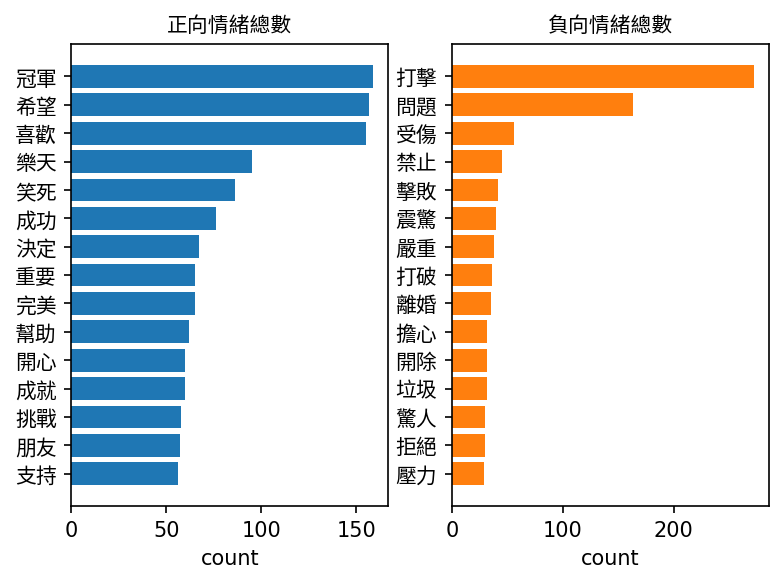

In [60]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)